# Imports and data uploa

In [ ]:
import torch 
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from google.colab import files

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
uploaded = files.upload()

Saving heart.csv to heart.csv


In [ ]:
heart = pd.read_csv("heart.csv")

# Data wrangling and preprocessing

In [ ]:
heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
categorical_columns = ["sex", "exng", "caa", "cp", "fbs", "restecg", "slp", "thall"]
continuous_columns = ["age","trtbps","chol","thalachh","oldpeak"]

df = pd.get_dummies(heart, columns = categorical_columns)
X = df.drop("output", axis = 1)
y = df["output"]

X[continuous_columns] = preprocessing.StandardScaler().fit_transform(X[continuous_columns])

X_train, X_test_full, y_train, y_test_full = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_validation, X_test, y_validation, y_test = train_test_split(X_test_full, y_test_full, test_size = 0.5, random_state = 42)

X_train = torch.tensor(X_train.values).float()
X_validation = torch.tensor(X_validation.values).float()
X_test = torch.tensor(X_test.values).float()
X_test_full = torch.tensor(X_test_full.values).float()

y_train = torch.tensor(y_train.values).float()
y_validation = torch.tensor(y_validation.values).float()
y_test = torch.tensor(y_test.values).float()
y_test_full = torch.tensor(y_test_full.values).float()

X_train.shape

torch.Size([212, 30])

In [ ]:
batch_size = 10
train = DataLoader(TensorDataset(X_train, y_train), batch_size)
validation = DataLoader(TensorDataset(X_validation, y_validation), batch_size)
test = DataLoader(TensorDataset(X_test, y_test), batch_size)
test_full = DataLoader(TensorDataset(X_test_full, y_test_full), batch_size)

# Neural Network model, train, test and benchmark

In [ ]:
class Net(nn.Module):

    def __init__(self, negative_slope=0, dropout_rate=0):
        super(Net, self).__init__()
        self.negative_slope = negative_slope
        self.dropout_rate = dropout_rate

        self.fc1 = nn.Linear(30, 64)  
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        leaky_relu = nn.LeakyReLU(self.negative_slope)
        x = nn.Dropout(self.dropout_rate)(leaky_relu(self.fc1(x)))
        x = nn.Dropout(self.dropout_rate)(leaky_relu(self.fc2(x)))
        x = nn.Dropout(self.dropout_rate)(leaky_relu(self.fc3(x)))
        x = self.fc4(x)
        return torch.sigmoid(x)

In [ ]:
def train_model(model, optimizer, criterion, train, nb_epochs = 100, print_loss = False):
    eta = 1e-1
    print_frequency = nb_epochs / 10
    for e in range(nb_epochs):
        acc_loss = 0

        for train_input, train_target in train:
            optimizer.zero_grad()
            output = model(train_input.float())
            loss = criterion(output, train_target.unsqueeze(1))
            
            acc_loss += loss.item()
            loss.backward()
            optimizer.step()

        if print_loss and e % print_frequency == 0 :
            print(f"Epoch {e}: Loss = {loss} ")
    
    return acc_loss

def compute_nb_errors(model, test, criterion):
    nb_errors = 0
    i = 0
    acc_loss = 0
    for test_input, test_target in test:
        output = model(test_input)
        loss = criterion(output, test_target.unsqueeze(1))
        acc_loss += loss
        predicted_classes = output > 0.5 
        for k in range(test_input.size(0)):
            if test_target[k] != predicted_classes[k]:
                nb_errors = nb_errors + 1
    return nb_errors, acc_loss.item()

In [ ]:
def benchmark_hyperparameters(train, test, dropout_rate=0, negative_slope=0, lr=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0, print_results=True):
  betas = beta_1, beta_2
  net = Net(negative_slope=negative_slope, dropout_rate=dropout_rate)
  optimizer = optim.Adam(net.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
  criterion = nn.MSELoss()
  loss_train = train_model(net, optimizer, criterion, train)
  nb_errors, loss = compute_nb_errors(net, test, criterion)
  accuracy = 100 * (1 - (nb_errors / len(test.dataset)))
  if print_results:
    print(f"Hyperparameters value: dropout_rate={dropout_rate}, negative_slope={negative_slope}, lr={lr}, betas={betas}, weight_decay={weight_decay}")
    print(f"Results: final loss {loss}, accuracy: {accuracy:.3f}")
    print("______________")
  return loss, accuracy

# Manual fine-tuning

In [ ]:
loss, accuracy = benchmark_hyperparameters(train, test, dropout_rate=0.1, negative_slope=0.1, lr=0.0001, beta_1=0.9, beta_2=0.9, weight_decay=0, print_results=True)

Hyperparameters value: dropout_rate=0.1, negative_slope=0.1, lr=0.0001, betas=(0.9, 0.9), weight_decay=0
Results: final loss 0.8472055792808533, accuracy: 78.261
______________


# Grid search

In [ ]:
def grid_search(train, validation, test, dropout_rate_array, negative_slope_array, lr_array, beta_1_array, beta_2_array, weight_decay_array):
  best_hyperparameters_loss = {}
  best_hyperparameters_accuracy = {}
  best_loss = 9999
  best_accuracy = 0
  results = []
  for dropout_rate in dropout_rate_array:
    for negative_slope in negative_slope_array:
      for lr in lr_array:
        for beta_1 in beta_1_array:
          for beta_2 in beta_2_array:
            for weight_decay in weight_decay_array:
              loss, accuracy = benchmark_hyperparameters(train, validation, dropout_rate, negative_slope, lr, beta_1, beta_2, weight_decay)
              iteration_dict = {}
              iteration_dict["dropout_rate"] = dropout_rate
              iteration_dict["negative_slope"] = negative_slope
              iteration_dict["lr"] = lr
              iteration_dict["beta_1"] = beta_1
              iteration_dict["beta_2"] = beta_2
              iteration_dict["weight_decay"] = weight_decay
              iteration_dict["loss"] = loss
              iteration_dict["accuracy"] = accuracy
              results.append(iteration_dict)

  for entry in results:
    if entry["loss"] < best_loss:
      best_hyperparameters_loss["dropout_rate"] = entry["dropout_rate"]
      best_hyperparameters_loss["negative_slope"] = entry["negative_slope"]
      best_hyperparameters_loss["lr"] = entry["lr"]
      best_hyperparameters_loss["beta_1"] = entry["beta_1"]
      best_hyperparameters_loss["beta_2"] = entry["beta_2"]
      best_hyperparameters_loss["weight_decay"] = entry["weight_decay"]
      best_loss = entry["loss"]
    if entry["accuracy"] > best_accuracy:
      best_hyperparameters_accuracy["dropout_rate"] = entry["dropout_rate"]
      best_hyperparameters_accuracy["negative_slope"] = entry["negative_slope"]
      best_hyperparameters_accuracy["lr"] = entry["lr"]
      best_hyperparameters_accuracy["beta_1"] = entry["beta_1"]
      best_hyperparameters_accuracy["beta_2"] = entry["beta_2"]
      best_hyperparameters_accuracy["weight_decay"] = entry["weight_decay"]
      best_accuracy = entry["accuracy"]

  final_results = {}

  dr_l, slope_l, lr_l, wd_l = best_hyperparameters_loss["dropout_rate"], best_hyperparameters_loss["negative_slope"], best_hyperparameters_loss["lr"], best_hyperparameters_loss["weight_decay"]
  beta_1_l, beta_2_l = best_hyperparameters_loss["beta_1"], best_hyperparameters_loss["beta_2"]
  betas_l = beta_1_l, beta_2_l
  final_results["best_loss_loss"], final_results["best_loss_accuracy"] = benchmark_hyperparameters(train, test, dr_l, slope_l, lr_l, beta_1_l, beta_2_l, wd_l, print_results=True)

  dr_a, slope_a, lr_a, wd_a = best_hyperparameters_accuracy["dropout_rate"], best_hyperparameters_accuracy["negative_slope"], best_hyperparameters_accuracy["lr"], best_hyperparameters_accuracy["weight_decay"]
  beta_1_a, beta_2_a = best_hyperparameters_accuracy["beta_1"], best_hyperparameters_accuracy["beta_2"]
  betas_a = beta_1_a, beta_2_a
  final_results["best_accuracy_loss"], final_results["best_accuracy_accuracy"] = benchmark_hyperparameters(train, test, dropout_rate=dr_a, negative_slope=slope_a, lr=lr_a, beta_1=beta_1_a, beta_2=beta_2_a, weight_decay=wd_a, print_results=True)


  best_loss_loss, best_loss_accuracy, best_accuracy_loss, best_accuracy_accuracy = final_results["best_loss_loss"], final_results["best_loss_accuracy"], final_results["best_accuracy_loss"], final_results["best_accuracy_accuracy"]
  print(f"\n \n \n \n====================================")
  print(f"Best loss hyperparameter values: dropout_rate={dr_l},"
        f"negative_slope={slope_l}, lr={lr_l}"
        f", betas={betas_l}, weight_decay={wd_l}")
  print(f"Loss on test with best loss hyperparameters: {best_loss_loss}")
  print(f"Accuracy on test with best loss hyperparameters: {best_loss_accuracy}")

  print(f"\n====================================")
  betas_accuracy = best_hyperparameters_accuracy["beta_1"], best_hyperparameters_accuracy["beta_2"]
  dr_a, slope_a, lr_a, wd_a = best_hyperparameters_accuracy["dropout_rate"], best_hyperparameters_accuracy["negative_slope"], best_hyperparameters_accuracy["lr"], best_hyperparameters_accuracy["weight_decay"]
  print(f"Best accuracy hyperparameter values: dropout_rate={dr_a},"\
        f"negative_slope={slope_a}, lr={lr_a}"\
        f", betas={betas_a}, weight_decay={wd_a}")
  print(f"Loss on test with best accuracy hyperparameters: {best_accuracy_loss}")
  print(f"Accuracy on test with best accuracy hyperparameters: {best_accuracy_accuracy}")

  return pd.DataFrame(results), final_results

In [ ]:
dropout_rate_array= [0, 0.15, 0.3] 
negative_slope_array = [0, 0.1, 0.2] 
lr_array = [1e-5, 1e-4, 1e-3] 
beta_1_array = [0.5, 0.75, 0.9] 
beta_2_array = [0.9, 0.999, 0.99999]
weight_decay_array = [0, 1e-7, 1e-5] 

results, final_benchmark = grid_search(train, validation, test, dropout_rate_array, negative_slope_array, lr_array, beta_1_array, beta_2_array, weight_decay_array)
results.to_csv("benchmark.csv")
files.download("benchmark.csv")

Hyperparameters value: dropout_rate=0, negative_slope=0, lr=1e-05, betas=(0.5, 0.9), weight_decay=0
Results: final loss 1.1507445573806763, accuracy: 84.444
______________
Hyperparameters value: dropout_rate=0, negative_slope=0, lr=1e-05, betas=(0.5, 0.9), weight_decay=1e-07
Results: final loss 1.1516939401626587, accuracy: 82.222
______________
Hyperparameters value: dropout_rate=0, negative_slope=0, lr=1e-05, betas=(0.5, 0.9), weight_decay=1e-05
Results: final loss 1.1139764785766602, accuracy: 88.889
______________
Hyperparameters value: dropout_rate=0, negative_slope=0, lr=1e-05, betas=(0.5, 0.999), weight_decay=0
Results: final loss 1.061532974243164, accuracy: 71.111
______________
Hyperparameters value: dropout_rate=0, negative_slope=0, lr=1e-05, betas=(0.5, 0.999), weight_decay=1e-07
Results: final loss 1.0606952905654907, accuracy: 86.667
______________
Hyperparameters value: dropout_rate=0, negative_slope=0, lr=1e-05, betas=(0.5, 0.999), weight_decay=1e-05
Results: final loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

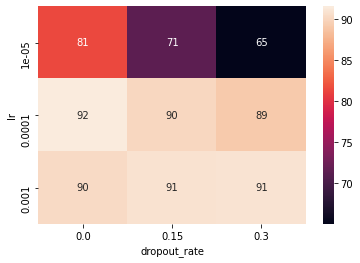

In [ ]:
results_plot = results[["lr", "dropout_rate", "accuracy"]].groupby(["lr", "dropout_rate"]).mean().reset_index()
results_plot = results_plot.pivot("lr", "dropout_rate", "accuracy")
sns.heatmap(results_plot, annot=True)

# Basic Random search

In [ ]:
def random_search(train, validation, test, initialization_vector, weight_vector, nb_iter):
  vector = initialization_vector
  gamma_list = [5, 1, 5e-1, 1e-1, 5e-2, 1e-2, 0, -1e-2, -5e-2, -1e-1, -5e-1, -1, -5]
  for i in range(nb_iter):
    random_vector = torch.rand(6) * 2 - 1
    random_vector_scaled = random_vector * weight_vector
    best_loss_iter = 999
    best_vector_iter = vector
    best_gamma_iter = 42
    best_accuracy = 0
    for gamma in gamma_list:
      vector_gamma = vector - gamma*random_vector_scaled
      vector_gamma[vector_gamma < 0] = 0
      vector_gamma[vector_gamma > 1] = 0.9999999
      loss, accuracy = benchmark_hyperparameters(train, validation, vector_gamma[0], vector_gamma[1], vector_gamma[2], vector_gamma[3], vector_gamma[4], vector_gamma[5], print_results=False)
      if loss < best_loss_iter:
        best_loss_iter = loss
        best_vector_iter = vector_gamma
        best_gamma_iter = gamma
        best_accuracy_iter = accuracy
    vector = best_vector_iter
    print(f"At iteration {i}, best vector is {vector} and loss is {best_loss_iter} with gamma factor {best_gamma_iter} and accuracy {best_accuracy_iter} ")
  print(f"=============")


  loss_test, accuracy_test = benchmark_hyperparameters(train, test, vector[0], vector[1], vector[2], vector[3], vector[4], vector[5])
  print(f"At the end of the random search, best vector is {vector} with associated loss {loss_test} and associated accuracy {accuracy_test}")


In [ ]:
pytorch_initialization = torch.Tensor([0, 0, 1e-3, 0.9, 0.999, 0])
weights = torch.Tensor([1e-1, 1e-1, 1e-3, 1e-1, 1e-3, 1e-8])
random_search(train, validation, test, pytorch_initialization, weights, 10)

At iteration 0, best vector is tensor([0.0000e+00, 0.0000e+00, 1.0162e-03, 8.9776e-01, 9.9903e-01, 1.8817e-10]) and loss is 0.16072429716587067 with gamma factor 0.05 and accuracy 95.55555555555556 
At iteration 1, best vector is tensor([0.0000e+00, 2.3367e-01, 5.4493e-03, 1.0000e+00, 1.0000e+00, 1.1975e-08]) and loss is 0.20000000298023224 with gamma factor 5 and accuracy 95.55555555555556 
At iteration 2, best vector is tensor([4.4822e-02, 2.3641e-01, 6.3947e-03, 1.0000e+00, 1.0000e+00, 1.4262e-08]) and loss is 0.3181741535663605 with gamma factor 1 and accuracy 93.33333333333333 
At iteration 3, best vector is tensor([0.0000e+00, 1.6065e-01, 5.9214e-03, 1.0000e+00, 9.9963e-01, 1.1310e-08]) and loss is 0.10192974656820297 with gamma factor 1 and accuracy 97.77777777777777 
At iteration 4, best vector is tensor([3.5221e-02, 1.4073e-01, 6.0675e-03, 9.6481e-01, 9.9928e-01, 7.4547e-09]) and loss is 0.2909809648990631 with gamma factor 0.5 and accuracy 93.33333333333333 
At iteration 5, b

In [ ]:
median_initialization = torch.Tensor([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
weight_median = torch.Tensor([1, 1, 1, 1, 1, 1])
random_search(train, validation, test, median_initialization, weight_median, 20)

At iteration 0, best vector is tensor([0.0000, 0.8042, 1.0000, 1.0000, 1.0000, 0.5063]) and loss is 0.4253215491771698 with gamma factor -1 and accuracy 88.88888888888889 
At iteration 1, best vector is tensor([0.0000, 0.7589, 1.0000, 1.0000, 1.0000, 0.4899]) and loss is 0.4859849512577057 with gamma factor 0.1 and accuracy 86.66666666666667 
At iteration 2, best vector is tensor([0.0000, 0.8004, 1.0000, 1.0000, 1.0000, 0.5122]) and loss is 0.5224184989929199 with gamma factor 0.05 and accuracy 86.66666666666667 
At iteration 3, best vector is tensor([0.0206, 1.0000, 1.0000, 1.0000, 1.0000, 0.4224]) and loss is 0.7671244144439697 with gamma factor 1 and accuracy 77.77777777777779 
At iteration 4, best vector is tensor([0.0206, 1.0000, 1.0000, 1.0000, 1.0000, 0.4224]) and loss is 0.7678804993629456 with gamma factor 0 and accuracy 80.0 
At iteration 5, best vector is tensor([0.0300, 1.0000, 1.0000, 1.0000, 1.0000, 0.4140]) and loss is 0.6842760443687439 with gamma factor -0.01 and accur

# Extended random search

In [ ]:
def generate_random_iterate(old_iterate):
  new_iterate = [1, 1, 1, 1, 1, 1]
  for (i, v) in enumerate(old_iterate):
    increase = rd.choice([True, False])
    value = np.random.uniform(v, 1)
    if increase:
      value = 1/value
    new_iterate[i] = v*value
  return (new_iterate, benchmark_hyperparameters(*new_iterate)[0])

def random_search_tree(trees=3, branches=5, n_iter=50, gaussian_random_variations=False):
  # All parameters stay between 0 and 1
  # weights = torch.Tensor([1e-1, 1e-1, 1e-3, 1e-1, 1e-3, 1e-8])
  rd_vectors = list([[0.0001, 0.0001, 1e-3, 0.9, 0.999, 0.0001] for i in range(trees)])
  # rd_vectors = list([np.random.uniform(0, 1, 6) for i in range(trees)])
  init_pop = list(map(lambda x: (x, benchmark_hyperparameters(*x)[0]), rd_vectors))
  pop = sorted(init_pop, key=lambda tup: tup[1])
  best_iterate = pop[0]
  for _ in range(n_iter):
    print("Best iterate : {}".format(best_iterate))
    pool = []
    for i in range(trees):
      pool.append(pop[i])
      for j in range(branches):
        pool.append(generate_random_iterate(pop[i][0]))
    pop = sorted(pool, key=lambda tup: tup[1])[:trees]
    best_iterate = pop[0]
    print("New population : {}".format(pop))
  return best_iterate

In [ ]:
def generate_random_crossover(v1, v2):
  new_iterate = []
  for i in range(len(v1)):
    get_first = rd.choice([True, False])
    if get_first:
      new_iterate.append(v1[i])
    else:
      new_iterate.append(v2[i])
  old_iterate = new_iterate.copy()
  for (i, v) in enumerate(old_iterate):
    nudge = rd.choice([True, False])
    if nudge:
      increase = rd.choice([True, False])
      value = np.random.uniform(v, 1)
      if increase:
        value = 1/value
      new_iterate[i] = v*value
  return (new_iterate, benchmark_hyperparameters(*new_iterate)[0])

def random_search_genetic(pop_size=10, n_iter=50, gaussian_random_variations=False):
  # All parameters stay between 0 and 1
  rd_vectors = list([[0.0001*(i+1), 0.0001*(i+1), 1e-3*(i+1), 0.9/(i+1), 0.999/(i+1), 0.0001*(i+1)] for i in range(pop_size)])
  init_pop = list(map(lambda x: (x, benchmark_hyperparameters(*x)[0]), rd_vectors))
  pop = sorted(init_pop, key=lambda tup: tup[1])
  best_iterate = pop[0]
  for _ in range(n_iter):
    print("Best iterate : {}".format(best_iterate))
    pool = []
    for i in range(pop_size):
      pool.append(pop[i])
      for j in range(pop_size)[i+1:]:
        pool.append(generate_random_crossover(pop[i][0], pop[j][0]))
    pop = sorted(pool, key=lambda tup: tup[1])[:pop_size]
    best_iterate = pop[0]
    print("New population : {}".format(pop))
  return best_iterate

# Benchmarking

In [ ]:
def benchmark(train, test, dropout_rate=0, negative_slope=0, lr=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0):
  array_loss = np.array([])
  array_acc = np.array([])
  for i in range(10):
    loss, acc = benchmark_hyperparameters(train, test, print_results = False)
    array_loss = np.append(array_loss, loss)
    array_acc = np.append(array_acc, acc)

  print(f"Average loss is {np.mean(array_loss)} and standard deviation is {np.std(array_loss)}")
  print(f"Average accuracy is {np.mean(array_acc)} and standard deviation is {np.std(array_acc)}")

In [ ]:
manual_picking = [0.1, 0.1, 0.0001, 0.9, 0.9, 0]
print(f"Manual picking")
benchmark(train, test, manual_picking[0], manual_picking[1], manual_picking[2], manual_picking[3], manual_picking[4], manual_picking[5])

print(f"==========")
print(f"Grid search loss")
grid_l = [0.15, 0.1, 0.001, 0.5, 0.9, 1e-7]
benchmark(train, test, grid_l[0], grid_l[1], grid_l[2], grid_l[3], grid_l[4], grid_l[5])

print(f"==========")
print(f"Grid search acc")
grid_a = [0, 0.2, 0.0001, 0.5, 0.999, 1e-7]
benchmark(train, test, grid_a[0], grid_a[1], grid_a[2], grid_a[3], grid_a[4], grid_a[5])

print(f"==========")
print(f"random search initialized")
random_i = [0.0000, 0.0000, 0.0038, 0.4603, 1.0000, 0.0000]
benchmark(train, test, random_i[0], random_i[1], random_i[2], random_i[3], random_i[4], random_i[5])

print(f"==========")
print(f"random search median")
random_m = random_i = [0, 0.6101, 1, 1, 1, 0.6688]
benchmark(train, test, random_m[0], random_m[1], random_m[2], random_m[3], random_m[4], random_m[5])

print(f"==========")
print(f"Method 1")
method_1 = [0.02461611955754215, 0.00013488036951462187, 0.0031084072969009783, 0.852471111047721, 0.9998966666366723, 1.3207879591899265e-05]
benchmark(train, test, method_1[0], method_1[1], method_1[2], method_1[3], method_1[4], method_1[5])

print(f"==========")
print(f"Method 2")
method_2 = [0.0004, 6.571766206276303e-06, 0.0005985845472056023, 0.003034251791715318, 0.9990298241543801, 0.00017028287280631955]
benchmark(train, test, method_2[0], method_2[1], method_2[2], method_2[3], method_2[4], method_2[5])


Manual picking
Average loss is 1.1761067867279054 and standard deviation is 0.09024718126845478
Average accuracy is 73.91304347826087 and standard deviation is 3.2244341248242
Grid search loss
Average loss is 1.1618168234825135 and standard deviation is 0.09873344238799109
Average accuracy is 74.1304347826087 and standard deviation is 2.9886363227972885
Grid search acc
Average loss is 1.2277533531188964 and standard deviation is 0.14925032769005642
Average accuracy is 71.95652173913045 and standard deviation is 4.175950589630118
random search initialized
Average loss is 1.1247656106948853 and standard deviation is 0.06524186661569115
Average accuracy is 74.78260869565217 and standard deviation is 1.4420107784153946
random search median
Average loss is 1.1488218307495117 and standard deviation is 0.14548331255511177
Average accuracy is 74.34782608695653 and standard deviation is 3.6115755925730744
Method 1
Average loss is 1.1771810412406922 and standard deviation is 0.11209744934326435
